在v4的基础上，将diffrax换成了别人的sde


In [1]:
!pip install diffrax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 5.2 MB/s 
     |████████████████████████████████| 66 kB 4.8 MB/s 


In [2]:
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 5.0 MB/s 
     |████████████████████████████████| 76 kB 5.8 MB/s 


In [3]:
!git clone https://github.com/xwinxu/bayeSDE.git

Cloning into 'bayeSDE'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 234 (delta 2), reused 2 (delta 2), pack-reused 228
Receiving objects: 100% (234/234), 47.82 MiB | 34.68 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [ ]:
#from jax.numpy import index_exp

'''
@partial(jit, static_argnums=(1, 2))
def sample_with_rep(rng, shape, rep):
    n = shape[0]
    z = random.normal(rng, shape)
    #z = index_update(z, index[n - rep:], z[n - rep * 2:n - rep])
    z.at[index_exp[n-rep:]].set(z[n-rep*2:n-rep])
    return z
'''

In [4]:
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union, NamedTuple
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import tqdm
import time

import diffrax
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
from jax import grad, jit, vmap, value_and_grad
import optax

from bayeSDE.jaxsde.jaxsde.sdeint import sdeint_ito

#from jax.experimental import stax
#from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten, Relu, Tanh,LogSoftmax)
#from jax.experimental import optimizers

In [5]:
# output values from 0 to maxval with iters steps
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1,iters)
        self._val = maxval/self._iters
        self._maxval = maxval
    
    def step(self):
        self._val = min(self._maxval, self._val+self._maxval/self._iters)
        
    @property
    def val(self):
        return self._val

In [6]:
class EMAMetric(object):
    def __init__(self, gamma: Optional[float]=0.99):
        super(EMAMetric, self).__init__()
        self._val=None
        self._gamma = gamma
    def step(self, x):
        if self._val is None:
            self._val = x
        else:
            self._val = self._gamma * self._val + (1-self._gamma)*x
        return self._val
    
    @property
    def val(self):
        return self._val

In [7]:
# make sure that the dvision is stable
def _stable_division(a,b,epsilon=1e-7):
    b = jnp.where(jnp.absolute(b)> epsilon, b, jnp.full_like(b, fill_value=epsilon)*jnp.sign(b))
    return a/b

## 5. Simulation of time series

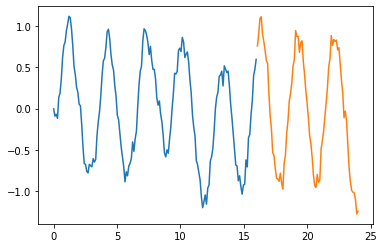

In [8]:
T = 240
t_end = 24.
t_start = 0.
t = np.linspace(t_start,t_end,T)

gap = 160
s = 30
mu = 0
sigma = 0.1
phi = 0.9
def make_time_series():
    z0 = np.random.normal(0,sigma,1)
    z = np.zeros(T)
    z[0] = z0
    shocks = np.random.normal(mu, sigma, T)
    for idx in range(T-1):
        idx_t = t[idx]
        z[idx+1] = phi*z[idx] + shocks[idx] + 0.2*np.sin(2*10*np.pi*(idx_t)/s)
    return z
r = make_time_series()
r_train = r[:gap]
r_test = r[gap:]
plt.plot(t[:gap],r_train)
plt.plot(t[gap:],r_test)
plt.show()


In [9]:
@jit
def make_data():
    ts_ = jnp.array(t)
    ts_ext_ = jnp.array([t_start-0.1] + list(ts_) + [t_end+0.1])
    ts_vis_ = jnp.linspace(t_start,t_end, 1000)
    ys_ = jnp.array(r[:,None])
    return ts_, ts_ext_, ts_vis_, ys_

In [118]:





class Constant(NamedTuple):
    theta: float
    mu: float
    sigma: float
    py0_mean: jnp.array
    py0_logvar: jnp.array


def init_MLP(layer_widths,parent_key, batch_size, scale=0.01,theta=1.0,mu=0.,sigma=2.):
    logvar = jnp.log(sigma**2/(2.*theta))
    params = []
    params.append([jnp.array([[mu]]),jnp.array([[logvar]])])
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)
    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params, Constant(theta,mu,sigma,jnp.array([[mu]]),jnp.array([[logvar]]))



@partial(jit,static_argnums=(2,))
def loss(params,variables,batch_size,ts,ys,kl_rate,key):
    zs, kl = forward(ts,batch_size,variables,params,key)
    zs = jnp.squeeze(zs)
    zs = zs[1:-1] 
    logpy = jax.scipy.stats.norm.logpdf(ys,loc=zs,scale=0.01).sum(axis=0).mean(axis=0)
    loss = -logpy + kl *kl_rate
    print("loss",loss)
    return loss

def forward(ts, batch_size,variables,params,key):
    theta, mu, sigma,py0_mean,py0_logvar = variables
    def f(y, t,args):
        t = jnp.full_like(y, t)
        print("f'y",y.shape)
        print("f't",t.shape)
        x = jnp.concatenate((jnp.sin(t),jnp.cos(t),jnp.sin(t**2),jnp.cos(t**2),y),axis=-1)
        print("f'x",x.shape)
        for w,b in params[1:-1]:
            x = jax.nn.relu(jnp.dot(w,x)+b)
        w_last,b_last = params[-1]
        x = jnp.dot(w_last,x)+b_last
        print("f'2x",x.shape)
        return x


    def g(y, t,args):  # Shared diffusion.
        res = jnp.full_like(y,sigma)
        print("g",res.shape)
        return res

    def h(y, t,args):  # Prior drift.
        res = theta * (mu - y)
        print("h",res.shape)
        return res

    def f_aug(y, t,args):  # Drift for augmented dynamics with logqp term.

        y = y[0:1] # 提取第一列，保持列的形态

        fv, gv, hv = f(y,t,args), g(y,t,args), h(y,t,args)

        u = _stable_division(fv - hv, gv) # 计算u(z,t)

        f_logqp = .5 * (u ** 2) # 计算integral

        res = jnp.concatenate([fv, f_logqp],axis=-1)
        print("f_aug",res.shape)
        return res

    def g_aug(y,t,args):  # Diffusion for augmented dynamics with logqp term.
        y = y[0:1]
        gv = g(y,t,args)
        g_logqp = jnp.zeros_like(y)
        res = jnp.concatenate([gv, g_logqp],axis=-1)
        print("g_aug",res.shape)
        return res
    t0 = ts[0]
    t1 = ts[-1]
    dt0 = 0.01
    py0_std = jnp.exp(.5 * py0_logvar)
    qy0_mean = params[0][0]
    qy0_std = jnp.exp(.5*params[0][1])
    eps_key,bm_key = jrandom.split(key,2)
    eps = jrandom.normal(key=eps_key,shape=(batch_size,1))
    y0 = qy0_mean + eps * qy0_std
    logqp0 = jnp.log(qy0_std/py0_std+(py0_std**2+(py0_mean-qy0_mean)**2)/(2*qy0_std**2)-0.5)
    logqp0 = logqp0.sum(axis=1)
    aug_y0 = jnp.concatenate([y0, jnp.zeros((batch_size,1))],axis=1)
    def int(rng,_y0):
        print("_y0",_y0.shape)
        sdeint_itop = jax.tree_util.Partial(sdeint_ito, ts=ts,y0=_y0,rng=rng, dt=dt0)
        return sdeint_itop(f_aug, g_aug)

    ints = jit(vmap(int))
    rngs = jrandom.split(bm_key,batch_size)
    aug_ys = ints(rngs,aug_y0)
    print("forward1",aug_ys.shape)
    aug_ys = aug_ys.reshape((batch_size, jnp.size(ts,0),2)).T
    print("forward2",aug_ys.shape)
    ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
    logqp = (logqp0+logqp_path).mean()
    return ys, logqp
    
def sample_p(ts, batch_size,variables, params,control,key):
    
    theta, mu, sigma, py0_mean,py0_logvar = variables
    def g(y,t,args):  # Shared diffusion.
        #return jnp.ones((jnp.size(y,0),1))*sigma
        return sigma

    def h(y,t,args):  # Prior drift.
        return theta * (mu - y)
    
    dt0 = 0.01
    py0_std = jnp.exp(.5*py0_logvar)
    eps_key,bm_key = jrandom.split(key,2)
    eps = jrandom.normal(key=eps_key,shape=(batch_size,1))
    y0 = py0_mean + eps * py0_std
    def int(rng,_y0):
        return sdeint_ito(h, g, _y0, ts, rng, dt=0.01)

    ints = jit(vmap(int))
    rngs = jrandom.split(bm_key,batch_size)
    ys = ints(rngs,y0)
    ys = ys.reshape((batch_size, jnp.size(ts,0))).T
    return ys
def sample_q(ts, batch_size, variables,params,eps,control,key):
    theta, mu, sigma, py0_mean,py0_logvar = variables
    def f(t, y,args):
        t = jnp.full_like(y, t)
        x = jnp.concatenate((jnp.sin(t),jnp.cos(t),jnp.sin(t**2),jnp.cos(t**2),y),axis=-1)
        def predict(x):
            for w,b in params[1:-1]:
                x = jax.nn.relu(jnp.dot(w,x)+b)
            w_last,b_last = params[-1]
            x = jnp.dot(w_last,x)+b_last
            return x
        
        x= vmap(predict)(x)
        return x

    def g(t, y,args):  # Shared diffusion.
        return jnp.ones((jnp.size(y,0),1))*sigma
    t0 = ts[0]
    t1 = ts[-1]
    dt0 = 0.01
    qy0_mean = params[0][1]
    qy0_std = jnp.exp(.5*params[0][1])
    eps_key,bm_key = jrandom.split(key,2)

    y0 = qy0_mean + eps * qy0_std
    vf = diffrax.ODETerm(f)
    cvf = diffrax.ControlTerm(g, control)
    terms = diffrax.MultiTerm(vf,cvf)
    solver = diffrax.Euler()
    saveat=diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(terms, solver, t0,t1,dt0,y0=y0,saveat=saveat,adjoint=diffrax.NoAdjoint())
    return sol.ys

In [119]:


def update(params, variables,batch_size,ts, ys, opt_state,opt_sgd,kl_rate,key):
    value, grads = value_and_grad(loss,argnums=(0))(params,variables,batch_size,ts,ys,kl_rate,key)
    #opt_state = opt_update(0,grads, opt_state)
    updates, opt_state = opt_sgd.update(grads,opt_state)
    params = optax.apply_updates(params, updates)
    return params,opt_state, value

In [120]:
def main(num_epochs = 500):
    
    
    ts, ts_ext, ts_vis, ys = make_data()
    key = jrandom.PRNGKey(1)
    batch_size = 256
    init_key,p_key,eps_key, bm_key,per_key,k1 = jrandom.split(key,6)

    '''
    init_net, net = stax.serial(Dense(200),Tanh,
                           Dense(200),Tanh,
                           Dense(1))
    '''
    sigma = jnp.std(ys)
    params, variables = init_MLP([5,200,200,1],init_key,batch_size,sigma=sigma)
    #opt_init, opt_update, get_params = optimizers.adam(1e-2)
    #opt_state = opt_init(params)
    opt_sgd = optax.adam(learning_rate=0.01)
    opt_state = opt_sgd.init(params)
    kl_scheduler = LinearScheduler(iters=100)
        
    logpy_metric = EMAMetric()
    kl_metric = EMAMetric()
    loss_metric = EMAMetric()

    vis_batch_size = 1024
    ylims = (-2., 2.)
    
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    vis_idx = jrandom.permutation(key=per_key,x=vis_batch_size)
    sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
    fill_color = '#9ebcda'
    mean_color = '#4d004b'
    num_samples = len(sample_colors)
    
    control = diffrax.VirtualBrownianTree(t0=ts_vis[0],t1=ts_vis[-1],tol=0.001,shape=(vis_batch_size,1),key=bm_key)
    #control = diffrax.UnsafeBrownianPath(shape=(),key=bm_key)
    #params = get_params(opt_state)
    
    # plot prior
    zs = sample_p(ts_vis,vis_batch_size,variables,params,control,p_key).squeeze()
    zs = jnp.sort(zs,axis=1)
    plt.subplot(frameon=False)
    for alpha, percentile in zip(alphas, percentiles):
        idx = int((1 - percentile) / 2. * vis_batch_size)
        zs_bot = zs[:, idx]
        zs_top = zs[:, -idx]
        
        plt.fill_between(ts_vis, zs_bot, zs_top, alpha=alpha, color=fill_color)

    
    plt.scatter(ts, ys, marker='x', zorder=3, color='k', s=35)  # Data.
    plt.plot(ts, ys, marker='x', zorder=3, color='k',label="observed $r_t$")
    #plt.plot(ts, z[:,None], color='g', linewidth=3.0, label=r"hidden variable $z_t$")
    plt.ylim(ylims)
    plt.xlabel('$t$')
    plt.ylabel('$Y_t$')
        
    plt.tight_layout()
    plt.legend()
    #plt.savefig('./img_diffrax/prior.png', dpi=300)
    plt.show()
    plt.close()
    
    # for loop
    for epoch in range(num_epochs):
        if (epoch+1) % 50 == 0:
            img_path = os.path.join("./img_diffrax/", f'global_step_{epoch+1}.png')
            zs = sample_q(ts_vis,batch_size,variables,params,eps,control,p_key).squeeze()
            plt.plot(ts_vis, zs.mean(axis=1), color='r',label=r'mean of latent variables')
            plt.scatter(ts, ys, marker='x', zorder=3, color='k', s=35)  # Data.
            plt.plot(ts, ys, marker='x', zorder=3, color='k',label="observed $r_t$")
            #plt.plot(ts, z[:,None], color='g', linewidth=3.0, label=r"hidden variable $z_t$")
            plt.ylim(ylims)
            plt.xlabel('$t$')
            plt.ylabel('$Y_t$')

            plt.tight_layout()
            plt.legend()
            #plt.savefig(img_path, dpi=300)
            plt.show()
            plt.close()
        start_time = time.time()
        params, opt_state, loss = update(params, variables,batch_size,ts_ext,ys, opt_state,opt_sgd,kl_scheduler.val,k1)
        
        loss_metric.step(loss)
        kl_scheduler.step()
        epoch_time = time.time()-start_time
        print("Epoch {} | T: {:0.2f} | loss {:0.3f}".format(epoch+1,epoch_time,loss))
        



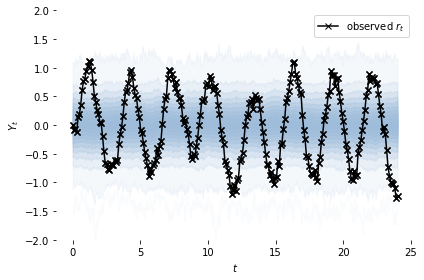

_y0 (2,)
f'y (1,)
f't (1,)
f'x (5,)
f'2x (1,)
g (1,)
h (1,)
f_aug (2,)
g (1,)
g_aug (2,)
g (1,)
g_aug (2,)
g (1,)
g_aug (2,)


CustomVJPException: ignored

In [121]:
logging.getLogger().setLevel(logging.INFO)

main()